In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date

In [2]:
import matplotlib.pyplot as plt

In [3]:
import os
import sys
from pathlib import Path
add_path = Path(os.getcwd()).parent
sys.path.append(str(add_path))

In [4]:
from engine.backtest_loop import evaluate_series
from dsl.parser import parse_alpha
from dsl.eval import EvaluationContext, eval_node
import dsl.functions  # ensure registry is loaded

In [5]:
def load_fields_from_csv(data_dir="data"):
    required = ["returns", "close", "volume"]
    paths = {name: os.path.join(data_dir, f"{name}.csv") for name in required}
    if all(os.path.exists(p) for p in paths.values()):
        fields = {
            name: pd.read_csv(paths[name], index_col=0, parse_dates=True) for name in required
        }
        return fields, True
    return None, False

In [6]:
def gen_synthetic_fields(n_days=250, symbols=("AAPL","MSFT","GOOG","AMZN","TSLA","NVDA"), seed=42):
    rng = np.random.default_rng(seed)
    dates = pd.date_range("2024-01-01", periods=n_days, freq="B")
    n = len(symbols)

    close = pd.DataFrame(100 + np.cumsum(rng.normal(0, 1, (n_days, n)), axis=0),
                         index=dates, columns=symbols)
    volume = pd.DataFrame(rng.integers(1e5, 5e6, (n_days, n)),
                          index=dates, columns=symbols)
    returns = close.pct_change().fillna(0.0)

    return {"close": close, "volume": volume, "returns": returns}

In [7]:
def save_fields_to_csv(fields, data_dir="data"):
    os.makedirs(data_dir, exist_ok=True)
    for name, df in fields.items():
        df.to_csv(os.path.join(data_dir, f"{name}.csv"))

In [8]:
def pandas_parity_checks(fields, t):
    """Return a dict of boolean results comparing DSL vs pandas for a couple of ops."""
    results = {}

    # ts_mean parity
    alpha = "ts_mean(returns, 5)"
    dsl = eval_node(EvaluationContext(fields, t), parse_alpha(alpha)).sort_index()
    pd_res = fields["returns"].rolling(5).mean().loc[t].sort_index()
    results["ts_mean==rolling_mean_5"] = bool((dsl.round(10) == pd_res.round(10)).all())

    # ts_std parity
    alpha = "ts_std(returns, 5)"
    dsl = eval_node(EvaluationContext(fields, t), parse_alpha(alpha)).sort_index()
    pd_res = fields["returns"].rolling(5).std(ddof=1).loc[t].sort_index()
    results["ts_std==rolling_std_5"] = bool((dsl.round(10) == pd_res.round(10)).all())

    # delay parity
    alpha = "delay(returns, 3)"
    dsl = eval_node(EvaluationContext(fields, t), parse_alpha(alpha)).sort_index()
    row = fields["returns"].index.get_loc(t)
    pd_res = fields["returns"].iloc[row-3].sort_index()
    results["delay_3_equals_shift"] = bool((dsl.round(10) == pd_res.round(10)).all())

    return results

In [9]:
fields, found = load_fields_from_csv(r"D:\research\desmos_for_alpha\desmos_for_alpha\data")

In [10]:
found

True

In [31]:
alpha = "ts_rank(ts_mean(close, 50) - ts_mean(close, 200), 2)"
# alpha = "close"

In [32]:
sig = evaluate_series(alpha, fields)

In [33]:
t = next(iter(fields.values())).index[-1]
checks = pandas_parity_checks(fields, t)

print("\nPandas parity checks @ last date", t.date(), ":")
for k, v in checks.items():
    print(f"  {k:30s} -> {v}")


Pandas parity checks @ last date 2025-10-03 :
  ts_mean==rolling_mean_5        -> True
  ts_std==rolling_std_5          -> True
  delay_3_equals_shift           -> True


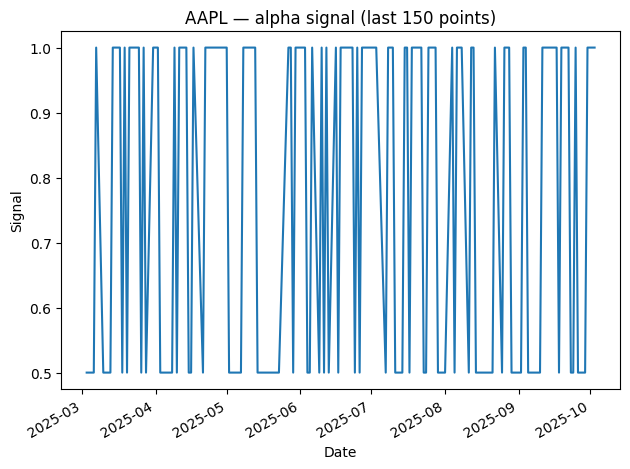

In [34]:
col = sig.columns[0]
window = sig.iloc[-150:][col]
ax = window.plot(title=f"{col} — alpha signal (last {len(window)} points)")
ax.set_xlabel("Date"); ax.set_ylabel("Signal")
plt.tight_layout(); plt.show()